<a href="https://colab.research.google.com/github/MostafaAshraf98/Google-Colab/blob/main/Clothes_Description_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#----------------------------IMPORTS----------------------------
import cv2
import io
import numpy as np
import os
import random
import pickle
import tensorflow as tf
import keras 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
#----------------------------UNZIP FILE AT GOOGLE COLAB---------------------------------

from zipfile import ZipFile
file_name = "Dataset 1.zip"
with ZipFile(file_name,'r') as zip_1:
  zip_1.extractall()
  print('Done')

In [2]:
#---------------------------- MOUNTING GOOGLE DRIVE AT GOOGLE COLAB---------------------
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#---------------------------READING DATASET LABELS----------------------

# images_path = "D:\Work\CCE\Year 4 - Senior 2\Semester 1\Senior-2-Semester-1\GP\Graduation-Project\Clothes Description Module\Datasets\Dataset 1\Images"
# csv_path = "D:\Work\CCE\Year 4 - Senior 2\Semester 1\Senior-2-Semester-1\GP\Graduation-Project\Clothes Description Module\Datasets\Dataset 1\CSV\images.csv"
images_path = "/content/drive/MyDrive/GP Colab/Dataset 1/Images"
csv_path = "/content/drive/MyDrive/GP Colab/Dataset 1/CSV/images.csv"
df = pd.read_csv(csv_path) # Reading the csv file into a dataframe using pandas
df.head() # Displaying the first 5 rows of the dataframe

# # Removing all entries with label = Not sure or label Other
df = df[df['label'] != 'Not sure']
df = df[df['label'] != 'Other']

#Remove colums: sender_id and kids
df = df.drop(['sender_id', 'kids'], axis=1)
df.head() # Displaying the first 5 rows of the dataframe

# Extract Unique Labels = Number of classes but remove the 'Not sure' and 'Other' labels
class_names = df['label'].unique()
num_classes = len(class_names)
class_ids = dict(zip(class_names, range(num_classes))) # Make a dictionary of class names and their corresponding ids

print(f'There are {num_classes} classes: {class_names}')

There are 18 classes: ['T-Shirt' 'Shoes' 'Shorts' 'Shirt' 'Pants' 'Skirt' 'Top' 'Outwear'
 'Dress' 'Body' 'Longsleeve' 'Undershirt' 'Hat' 'Polo' 'Blouse' 'Hoodie'
 'Skip' 'Blazer']


In [4]:
#------------------------------ RESIZING IMAGES - NUMBER OF FEATURES -------------------------------------
IMAGE_HEIGHT =  128
IMAGE_WIDTH = 128

In [5]:
#---------------------------READING IMAGES AND THEIR LABELS----------------------
images = []
images_labels = []

#Read all the images in the file with the path images_path
for filename in os.listdir(images_path):
    image_path = os.path.join(images_path, filename)
    image = cv2.imread(image_path)
    filename = filename.split('.')[0]
    label = df.loc[df['image'] == filename]['label']
    if(label.empty or image is None):
        continue
    label = label.values[0]
    image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
    images.append(image)
    images_labels.append(class_ids[label])
        
# Convert the images and labels to numpy arrays        
images = np.array(images, dtype=np.float32)
images_labels = np.array(images_labels, dtype=np.int32)

In [6]:
#Normalize the images
images = images / 255.0

In [7]:
#----------------------------------------DATA SPLITTING----------------------------------------

# Split the dataset into 70% for training and 15% for testing and 15% for cross-validation
trainval_images, x_test, trainval_labels, y_test = train_test_split(images, images_labels, test_size=0.15, random_state=42)

x_train, x_cv, y_train, y_cv = train_test_split(trainval_images, trainval_labels, test_size=0.15/0.85, random_state=42)

m_train = len(x_train)
m_test = len(x_test)
m_cv = len(x_cv)

del trainval_images
del trainval_labels

# Print the size of each set
print(f"Dataset Size: {images.shape[0]}")
print(f"Training set size: {m_train} images")
print(f"Cross-validation set size: {m_cv} images")
print(f"Testing set size: {m_test} images")

Dataset Size: 5103
Training set size: 3571 images
Cross-validation set size: 766 images
Testing set size: 766 images


In [8]:
#--------------------------------------DATA AUGMENTATION-----------------------------------------

# Define image data generator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,  # randomly rotate images by up to 40 degrees
    width_shift_range=0.3,  # randomly shift images horizontally by up to 30%
    height_shift_range=0.3,  # randomly shift images vertically by up to 30%
    shear_range=0.2,  # randomly apply shearing transformations
    zoom_range=0.3,  # randomly zoom in on images by up to 30%
    channel_shift_range=20,  # randomly adjust brightness
    brightness_range=[0.5, 1.5],  # randomly adjust brightness
    horizontal_flip=True,  # randomly flip images horizontally
    vertical_flip=True,  # randomly flip images vertically
    fill_mode='nearest'  # fill in any gaps with the nearest pixel value
)

x_train = x_train * 255.0
# Fit the data generator to your training data
datagen.fit(x_train)

# Define a function to generate augmented images and labels
def generate_augmented_data(x, y, batch_size):
    gen = datagen.flow(x, y, batch_size=batch_size)
    while True:
        x_batch, y_batch = gen.next()
        yield x_batch, y_batch

# Set batch size for training
batch_size = 500

# Generate augmented images and labels using the function defined above
augmented_data = generate_augmented_data(x_train, y_train, batch_size)
x_augmented, y_augmented = next(augmented_data)

# Concatenate the original training set and the augmented images
x_train = np.concatenate((x_train, x_augmented))
x_train = x_train / 255.0
m_train = x_train.shape[0]

# Concatenate the original labels and the augmented labels
y_train = np.concatenate((y_train, y_augmented))
y_train = np.reshape(y_train,(y_train.shape[0],1))

print(m_train)
print(x_train.shape)
print(y_train.shape)


(4071, 128, 128, 3)
(4071, 1)


Image shape is (128, 128, 3) with max value = 1.0
['T-Shirt']


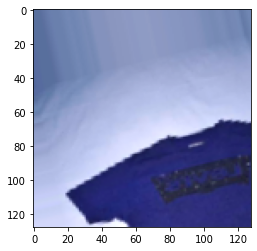

In [12]:
#-------------------------SHOWING ONE IMAGE--------------------------------------
# image = x_augmented[1]/255.0
# label = y_augmented[1]
image = x_train[4000]
label = y_train[4000]
print(f"Image shape is {image.shape} with max value = {np.max(image)}")
category = class_names[label]
print(category)
plt.imshow(image)
plt.show()

In [13]:
#----------------------------------------BUILD MODEL USING TRANSFER LEARNING----------------------------------------

# Use ResNet pretrained model
# Load the pre-trained ResNet50 model without the top layer (i.e., the fully connected layers)
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

# Freeze the pre-trained layers to avoid changing their weights during training
for layer in resnet_model.layers:
    layer.trainable = True

# Add a new fully connected layer for the specific classification task
x = Flatten()(resnet_model.output)
x = Dense(512, activation='relu', input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3),kernel_regularizer=tf.keras.regularizers.l2(0.5))(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = Dense(num_classes, activation='linear', input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3),kernel_regularizer=tf.keras.regularizers.l2(0.5))(x)

# Create a new model by combining the pre-trained ResNet50 model with the new fully connected layers
model = Model(inputs=resnet_model.input, outputs=x)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
#----------------------------------------BUILD MODEL USING CNN----------------------------------------

# Create a convolutional neural network (CNN)
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3), name = 'Conv1'),
    tf.keras.layers.MaxPooling2D(2, 2, name = 'Max1'),
    tf.keras.layers.Conv2D(64, (5, 5), padding = 'same', activation='relu', name = 'Conv2'),
    tf.keras.layers.MaxPooling2D(2, 2, name = 'Max2'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', name = 'Conv3'),
    tf.keras.layers.MaxPooling2D(2, 2, name = 'Max3'),
    tf.keras.layers.Conv2D(512, (5, 5), strides = 2, activation='relu', name = 'Conv4'),
    tf.keras.layers.MaxPooling2D(2, 2, name = 'Max4'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), name = 'Dense1'),    
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), name = 'Dense2'),    
    tf.keras.layers.Dense(len(class_names), activation='linear', name = 'Dense3')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


In [14]:
#-----------------------------------------------TRAINING----------------------------------------

# Define the EarlyStopping callback
# the training process will stop if the validation loss does not improve after 4 epochs.
early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1)

# Define the ModelCheckpoint callback
# his callback can be used to save the best model weights during training based on a given metric (e.g., validation accuracy or loss).
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)

history = model.fit(x_train, y_train, epochs=20, batch_size=30, validation_data=(x_cv, y_cv),callbacks=[early_stopping,checkpoint])
# history = model.fit(x_train, y_train, epochs=20, batch_size=30, validation_data=(x_cv, y_cv))

Epoch 1/20
136/136 [==============================] - 58s 158ms/step - loss: 230.4894 - accuracy: 0.5235 - val_loss: 75.4173 - val_accuracy: 0.0927
Epoch 2/20
136/136 [==============================] - 18s 129ms/step - loss: 33.9576 - accuracy: 0.7794 - val_loss: 21.8613 - val_accuracy: 0.0248
Epoch 3/20
136/136 [==============================] - 17s 124ms/step - loss: 11.3743 - accuracy: 0.8725 - val_loss: 11.3609 - val_accuracy: 0.0692
Epoch 4/20
136/136 [==============================] - 20s 148ms/step - loss: 6.6133 - accuracy: 0.9275 - val_loss: 7.8852 - val_accuracy: 0.2402
Epoch 5/20
136/136 [==============================] - 22s 161ms/step - loss: 4.3880 - accuracy: 0.9479 - val_loss: 5.0656 - val_accuracy: 0.5509
Epoch 6/20
136/136 [==============================] - 20s 147ms/step - loss: 2.9287 - accuracy: 0.9693 - val_loss: 3.3304 - val_accuracy: 0.7350
Epoch 7/20
136/136 [==============================] - 20s 146ms/step - loss: 1.9846 - accuracy: 0.9745 - val_loss: 2.2646 -

In [ ]:
#----------------------------------DELETE MODEL----------------------------------
del model

In [ ]:
#-----------------------------------SAVE MODEL-----------------------------------
# model_path = 'clothing_detector.pkl'
model_path = "/content/drive/MyDrive/GP Colab/clothing_detector.pkl"
pickle.dump(model, open(model_path, 'wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_10
.........vars
......activation_11
.........vars
......activation_12
.........vars
......activation_13
.........vars
......activation_14
.........vars
......activation_15
.........vars
......activation_16
.........vars
......activation_17
.........vars
......activation_18
.........vars
......activation_19
.........vars
......activation_2
.........vars
......activation_20
.........vars
......activation_21
.........vars
......activation_22
.........vars
......activation_23
.........vars
......activation_24
.........vars
......activation_25
.........vars
......activation_26
.........vars
......activation_27
.........vars
......activation_28
.........vars
......activation_29
.........vars
......activation_3
.........vars
......activation_30
.........vars
......activation_31
.........vars
......activation_32
.........vars
......activa

In [15]:
#--------------------------------LOADING MODEL FROM CHECKPOINT-------------------------
model.load_weights('best_model.h5')

In [ ]:
#-------------------------------- LOADING MODEL FROM PICKL FILE ------------------------
# Load the saved model from a .pkl file
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)


In [16]:
#----------------------------------------PREDICTIONS----------------------------------------
train_predictions = model.predict(x_train)
cv_predictions = model.predict(x_cv)
test_predictions = model.predict(x_test)

train_count_correct = 0
cv_count_correct = 0
test_count_correct = 0

for i in range(m_train):
    predicted = np.argmax(train_predictions[i])
    if (predicted == y_train[i]):
        train_count_correct += 1
train_accuracy = train_count_correct / m_train

for i in range(m_test):
    predicted = np.argmax(test_predictions[i])
    if (predicted == y_test[i]):
        test_count_correct += 1
test_accuracy = test_count_correct / m_test

for i in range(m_cv):
    predicted = np.argmax(cv_predictions[i])
    if (predicted == y_cv[i]):
        cv_count_correct += 1
cv_accuracy = cv_count_correct / m_cv

print("Train Accuracy = %.2f" % (train_accuracy*100),'% with', m_train, 'training examples')
print("CV Accuracy = %.2f" % (cv_accuracy*100),'% with', m_cv, 'cv examples')
print("Test Accuracy = %.2f" % (test_accuracy*100),'% with', m_test, 'test examples')


24/24 [==============================] - 1s 34ms/step
Train Accuracy = 99.26 % with 4071 training examples
CV Accuracy = 85.25 % with 766 cv examples
Test Accuracy = 83.81 % with 766 test examples
